### Machine Learning Homework - Alternus Vera

Course code : **CMPE-257** 
    
Group name : **Codebusters**
    
Name: **Harini Balakrishnan (010830755)** 

- GitHub URL https://github.com/HariniGB/MachineLearning/AlternusVera
    
----

STEP 1: Read the Fake News article https://arxiv.org/pdf/1708.01967.pdf
        
STEP 2: List the top factors derive from the above article:
        
        1. Social acceptance = # of likes, # of comments (short term utility)
        2. Bias Score
        3. Spam Score
        4. Website credibility/ Domain Ranking
        5. Author credibility
        6. Political Affliation
        7. Occurance Location (Probability of announcing on Radio or Press release being fake is low)
        8. Sensationalism/Psychology Utility - agreeing with reader's prior beliefs
        9. Frequency Heuristic - Constant repetition makes them believe (Sensationlism)
        10. Echo Chamber - Forming groups and spreading opinions
        11. Visual - Images, Links, Videos
    
----
    
STEP 3: Distillation of subset factors from Kaggle Fake News dataset
    
Subset Factors: **Sentiment Analysis/Sensationalism, Bias Score and Social Acceptance** 
    
##### Datasources
1. https://www.kaggle.com/mrisdal/fake-news#fake.csv 
The dataset contains text and metadata from 244 websites and represents 12,999 posts in total from the past 30 days. The data was pulled using the webhose.io API. It contains text and metadata scraped from 244 websites tagged as "bullshit" by the BS Detector.

It has columns:
    * uuid - Unique identifier
    * ord_in_thread
    * author - author of story
    * published - date published
    * title - title of the story
    * text - text of story
    * language - data from webhose.io
    * crawled - date the story was archived
    * site_url - site URL from BS detector
    * country - data from webhose.io
    * domain_rank - data from webhose.io
    * thread_title
    * spam_score - data from webhose.io
    * main_img_url - image from story
    * replies_count - number of replies
    * participants_count - number of participants
    * likes - number of Facebook likes
    * comments - number of Facebook comments
    * shares - number of Facebook shares
    * type - type of website (label from BS detector)

##### Data Enrichement 
1. sources.json from the OpenSources that are publicly accessible in github. Used to fill the missing defaulted as'bs'in the dataset. If the urls matches it takes the appropriate type and replaces in the fake.csv file from the sources.json 

2. International Survey on Emotion Antecedents and Reactions (ISEAR) Databank is used to train the classifier for sentiment analysis. It provides isear_databank.mdb which is converted to isear.csv and parsed into the lists of training data. 

##### Exploration 

1. There is a bias in the data. Looks like the dataset has large data scrapped in the first few days and then after time passed, smaller amount of data is added. 

2. Another possible scenario is that if we consider the data to be legitimate/unbiased, the decrease in the article count might be the effect of a sudden event. 

#####  Types of Fake News 

- **Fake News:**  News that are fabricated with stories to prank the public
- **Satire:** News that has humorous comments on current events in the form of fake news.
- **Junk Science:** News with scientifically dubious claims like metaphysics, pseduoscience etc.
- **Hate Group:** News to promote racism, homophobia, misogyny and other form ofdiscriminations.
- **Clickbait:** News to generate online advertising revenue, sensationalist headlines or eye-catching pictures. 
- **Extreame Bias:** News realted to political propaganda and gross distortions of fact. 
- **Conspiracy Theory:** News that are based on promoting conspiracy theories. 
- **Rumor Mill:** News based on rumors, unverified claims. 
- **State News:** News from the government sources to represent operations.


##### Problem statements
- Sentiment Analysis using NLTK 
- Topic modelling and list topics using LDA for each news type
- Create 3 classification models that assess at least three of these factors
- Compute the importance and the relevance with the weightage (1-10). 
- Create corresponding weights for your polynomial equation for coming up with a Fake News score

# Kaggle Fake News Data Set 

### Load the dataset 

In [1]:
# import dependencies
%matplotlib inline
import sys, os
import glob
import pandas as pd
import numpy 
import re
import random
import time
import matplotlib
from sklearn.feature_extraction.text import TfidfTransformer
import warnings
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import csv
import sqlite3
import sklearn
import datetime
import json
from string import punctuation
import sklearn.linear_model
import sklearn.metrics
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF
import matplotlib.style as style
style.use('fivethirtyeight')
import nltk
import nltk.sentiment
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist
import textblob
import gensim  # Train an LDA model using a Gensim corpus
from gensim.models import LdaModel
from gensim import models, corpora, similarities
from scipy.stats import *
from scipy.stats import entropy
sns.set()
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=UserWarning)

/Users/harinibalakrishnan/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# csv file is large so the field_size_limit must be increased
# maxsize can't be converted to long because it is too large so try except decreases size until it works]

maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt/10)
        decrement = True


def load_csv(filename):
    """Loads csv and saves data in a list of dictionaries"""
    csv_list = []
    with open(filename, encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            csv_list.append({"author": row["author"], "date": row["published"],"title": row["title"], "text":row["text"],"site_url": row["site_url"], "type": row["type"]})
    return csv_list

original_news_data = load_csv("input_data/fake.csv")
news_data = load_csv("input_data/fake.csv")
word_news_data = load_csv("input_data/fake.csv") 

In [3]:
df = pd.read_csv('input_data/fake.csv', usecols = ['author', 'published', 'title','text','language','site_url','type', 'site_url', 'likes', 'shares', 'comments'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head(5)

,author,published,title,text,language,site_url,likes,comments,shares,type
0,para para dinle,2016-10-30T14:26:58.866+02:00,Comment on 10 Questions For Every Atheist by p...,10 Questions For Every Atheist By Jonathan Len...,english,liberalamerica.org,0,0,0,bs
1,Truth Broadcast Network,2016-11-19T16:59:00.000+02:00,Keiser Report: Meme Wars (E995),42 mins ago 1 Views 0 Comments 0 Likes 'For th...,english,truthbroadcastnetwork.com,0,0,0,bs
2,Michael Snyder,2016-10-31T07:00:14.223+02:00,Will Michelle Obama Be The Replacement Nominee...,Email \nI realize that this headline must soun...,english,freedomoutpost.com,0,0,0,bs
3,NaN,2016-10-29T12:00:00.000+03:00,"FBI Found ""Tens Of Thousands Of Emails"" Belong...","FBI Found ""Tens Of Thousands Of Emails"" Belong...",english,blacklistednews.com,0,0,0,bs
4,King World News,2016-11-22T09:44:39.517+02:00,Look At The Stunning Levels Of Extreme Action ...,"22 Views November 21, 2016 GOLD , KWN King Wor...",english,kingworldnews.com,0,0,0,bs


In [4]:
original_news_data

[{'author': 'Barracuda Brigade',
  'date': '2016-10-26T21:41:00.000+03:00',
  'title': 'Muslims BUSTED: They Stole Millions In Gov’t Benefits',
  'text': 'Print They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? \nHere we go again …another group stealing from the government and taxpayers! A group of Somalis stole over four million in government benefits over just 10 months! \nWe’ve reported on numerous cases like this one where the Muslim refugees/immigrants commit fraud by scamming our system…It’s way out of control! More Related',
  'site_url': '100percentfedup.com',
  'type': 'bias'},
 {'author': 'reasoning with facts',
  'date': '2016-10-29T08:47:11.259+03:00',
  'title': 'Re: Why Did Attorney General Loretta Lynch Plead The Fifth?',
  'text': 'Why Did Attorney General Loretta Lynch Plead The Fifth? Barracuda Brigade 2016-10-28 Print The administration is bl

###  Data Preprocesing 
- Clean Text 
- Remove Stop Words
- Stemming 
- Tokenize the words

In [5]:
# Function to clean text of websites, email addresess and any punctuation
def initial_clean(text):
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text


# Function to removes all stopwords from text
stop_words = stopwords.words('english')
def remove_stop_words(text):    
    return [word for word in text if word not in stop_words]



# Function to stem words, so plural and singular are treated the same
stemmer = PorterStemmer()
def stem_words(text):     
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

# Single function to perform/call all above functions 
def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

In [6]:
# clean text andtitle 
# create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 4.057020552953085 min


### Sentiment Analysis using NLTK

- In order to classify whether the news is fake or not, I'm using the Reuters Corpus from NLTK to get some more news articles from a reliable source. Avoid balance issues. 
- In order to classify whether a news is True or False, the vocabulary must not be too biased. Whereas the features not based on the vocabulary harder to be faked and hence helps the classification process. 


##### My Solution: 
- Structure each sentence in the Text and Title using textblob library
- To overcome the dimentionality issues in the sentences, I'm doing Latent Semantic Indexing.
- Get the list of Sentiment features using the VADER (A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text) NLTK tool. 
- Perform 3 X classification ("positive", "negative", "neutral") model using Logistic Regression.

In [7]:
sentence_splitter=re.compile(u"""[.?!]['"]*\s+""",re.UNICODE)
def sentence_structure_features(document):
    return ['_'.join((pos for (word,pos) in sentence.pos_tags))
            for sentence in textblob.blob.TextBlob(document).sentences]

In [8]:
class SentenceStructureCorpus(object):
    def __init__(self):
        n_lies=df.shape[0]
        self.vader=nltk.sentiment.vader.SentimentIntensityAnalyzer()
        print("Converting Fake News corpus")
        self.data=[sentence_structure_features('{0}\n{1}'.format(row['title'],row['text']))
                   for (index,row) in df.iterrows()]
        sentiments=[self.analyse_sentiments('{0}\n{1}'.format(row['title'],row['text']))
                    for (index,row) in df.iterrows()]
        reuters=nltk.corpus.reuters
        print('Converting Reuters corpus')
        self.data.extend([sentence_structure_features(reuters.raw(fileid))
                          for fileid in reuters.fileids()])
        sentiments.extend([self.analyse_sentiments(reuters.raw(fileid))
                           for fileid in reuters.fileids()])
        self.sentiments=numpy.array(sentiments)
        self.N=len(self.data)
        self.labels=numpy.ones(self.N)
        self.labels[:n_lies]=0
        self.test_sample=random.sample(range(self.N),self.N//10)
        print("Creating dictionary")
        self.dictionary=gensim.corpora.dictionary.Dictionary(self.data)
        
    def __iter__(self):
        return (self.dictionary.doc2bow(document) for document in self.data)
                          
    def analyse_sentiments(self,document):
        valences=numpy.array([[sent['pos'],sent['neg'],sent['neu']]
                             for sent in (self.vader.polarity_scores(sentence)
                                          for sentence in sentence_splitter.split(document))])
        return valences.sum(axis=0)
    
    def training_data(self):
        return [self.dictionary.doc2bow(document) for (i,document) in enumerate(self.data)
                if i not in self.test_sample]
                
    def training_labels(self):
        return self.labels[[i for i in range(self.N) if i not in self.test_sample]]
    
    def training_sentiments(self):
        return self.sentiments[[i for i in range(self.N) if i not in self.test_sample]]
    
    def test_sentiments(self):
        return self.sentiments[self.test_sample]
                
    def test_data(self):
        return [self.dictionary.doc2bow(self.data[i])
                for i in self.test_sample]
            
    def test_labels(self):
        return self.labels[self.test_sample]

In [9]:
# nltk.download('vader_lexicon')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('reuters')
ssf=SentenceStructureCorpus()
print("Training LSI")
lsi=gensim.models.lsimodel.LsiModel(ssf)      #To implements fast truncated SVD (Singular Value Decomposition)

Converting Fake News corpus
Converting Reuters corpus
Creating dictionary
Training LSI


####  Logistic Regression Classifier on training and test data

Training classifier
Testing classifier


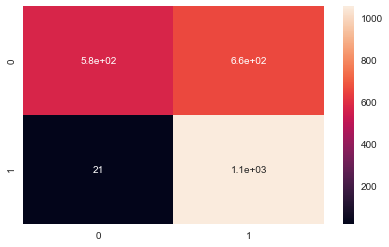

In [10]:
vectors=gensim.matutils.corpus2dense(lsi[ssf.training_data()],lsi.num_topics).T
classifier=sklearn.linear_model.LogisticRegression()
print("Training classifier")
y_pred = classifier.fit(vectors,ssf.training_labels())
print("Testing classifier")
confusion=sklearn.metrics.confusion_matrix(ssf.test_labels(),
                                           classifier.predict(gensim.matutils.corpus2dense(lsi[ssf.test_data()],
                                                                                           lsi.num_topics).T))
sns.heatmap(confusion,annot=True)

In [11]:
def precision(cm):
    return cm[1,1]/cm[:,1].sum()

def recall(cm):
    return cm[1,1]/cm[1].sum()

def accuracy(cm):
    return (cm[0,0]+cm[1,1])/cm.sum()

def matthews(cm):
    return (cm[0,0]*cm[1,1]-cm[1,0]*cm[0,1])/numpy.sqrt(cm[0].sum()*cm[1].sum()*cm[:,0].sum()*cm[:,1].sum())

In [12]:
print("Precision:" , precision(confusion) )
print("Recall:" , recall(confusion) )
print("Accuracy:" , accuracy(confusion) )
print("Matthews:" , matthews(confusion) ) #measure of the quality of binary and multiclass classifications

Precision: 0.6140861466821886
Recall: 0.9804832713754646
Accuracy: 0.7044079515989629
Matthews: 0.5074990400326409


#### Logistic Regression Classifier on the training and test  sentiments data

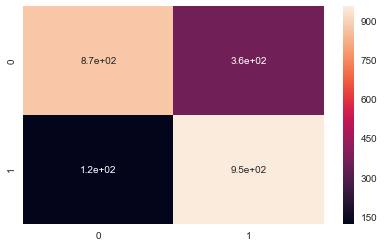

In [13]:
sentiment_classifier=sklearn.linear_model.LogisticRegression()
sentiment_classifier.fit(ssf.training_sentiments(),ssf.training_labels())
confusion=sklearn.metrics.confusion_matrix(ssf.test_labels(),
                                           sentiment_classifier.predict(ssf.test_sentiments()))
sns.heatmap(confusion,annot=True)

In [14]:
print("Precision:" , precision(confusion) )
print("Recall:" , recall(confusion) )
print("Accuracy:" , accuracy(confusion) )
print("Matthews:" , matthews(confusion) )

Precision: 0.723823975720789
Recall: 0.8866171003717472
Accuracy: 0.7899740708729472
Matthews: 0.59694825604931


##### Inferences: 
> We can see that this classifier rejects more False articles, at the expense of rejecting more True ones. Precision is 74%, recall is 87%, accuracy 79% and Matthews 60%.

#### Logistic Regression Classifier on training and test data with sentiment features extracted from Sentiment Analysis 

Training classifier
Testing classifier


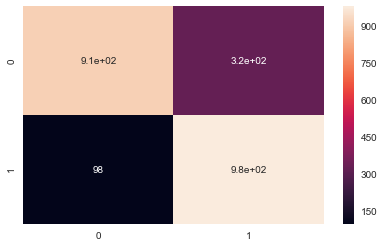

In [15]:
enhanced_vectors=numpy.hstack([vectors,ssf.training_sentiments()])
combined_classifier=sklearn.linear_model.LogisticRegression()
print("Training classifier")
combined_classifier.fit(enhanced_vectors,ssf.training_labels())
print("Testing classifier")
enhanced_test_vectors=numpy.hstack([gensim.matutils.corpus2dense(lsi[ssf.test_data()],
                                                                 lsi.num_topics).T,
                                    ssf.test_sentiments()])
confusion=sklearn.metrics.confusion_matrix(ssf.test_labels(),
                                           combined_classifier.predict(enhanced_test_vectors))
sns.heatmap(confusion,annot=True)

In [16]:
print("Precision:" , precision(confusion) )
print("Recall:" , recall(confusion) )
print("Accuracy:" , accuracy(confusion) )
print("Matthews:" , matthews(confusion) )

Precision: 0.750575594781274
Recall: 0.9089219330855018
Accuracy: 0.817199654278306
Matthews: 0.6500117221120467


#### Sentiment Result: 
> Thus sentiment features helps better to detect whether the news is fake or not with 82% accuracy rate  

#### Data Enrichment 

> **International Survey on Emotion Antecedents and Reactions** (ISEAR) Databank is used to train the classifier for sentiment analysis. It provides isear_databank.mdb which is converted to isear.csv and parsed into the lists of training data.

In [17]:
def get_sentiment_data(filename):    
    emotions_dict = {'joy': 1,'anger': 2,'fear': 3,'sadness': 4,'guilt': 5,'shame':6,'disgust':7}
    csv_list = []
    list_1 = []
    list_2 = []
    
    with open(filename, encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            list_1.append(emotions_dict[row['emotion']])
            list_2.append(row['text'])
            
    csv_list.append(list_1)
    csv_list.append(list_2)
    return csv_list

sentiment = get_sentiment_data("input_data/isear.csv")

def totals(data, sum_type):
    """Returns a descending sorted tuple that holds the counts of the type of data that is passed in"""
    sum_dict = {}
    for dicts in data:
        if dicts[sum_type] in sum_dict.keys():
            sum_dict[dicts[sum_type]] += 1
        else:
            sum_dict[dicts[sum_type]] = 1
    
    sum_dict = sorted(sum_dict.items(), key=lambda t : t[1], reverse=True)
    return sum_dict

def add_sentiment(data, training_data):
    """Adds Naive Bayes sentiment analysis on the title of 
    each article, as well as the text. Returns a list of dictionaries with new
    sentiment key/value pair. 
    
    Training data is a list of lists
    """
    emotions_dict = {'joy': 1,'anger': 2,'fear': 3,'sadness': 4,'guilt': 5,'shame':6,'disgust':7}
    
    sentiment = Pipeline([('vect', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('clf', MultinomialNB()),])
    sentiment.fit(training_data[1],training_data[0])
    
    for dicts in data:
        to_predict_text = []
        to_predict_text.append(dicts['text'])
        to_predict_title = []
        to_predict_title.append(dicts['title'])
        predicted_text = sentiment.predict(to_predict_text)
        predicted_title = sentiment.predict(to_predict_title)
        for keys, values in emotions_dict.items():
            if values == predicted_text:
                dicts["text_sentiment"] = keys
            if values == predicted_title:
                dicts["title_sentiment"] = keys
    return data
        
new_data = add_sentiment(word_news_data, sentiment)

title_sentiment = totals(new_data, 'title_sentiment')
text_sentiment = totals(new_data, 'text_sentiment')

[0.40387722132471726, 0.2678667589814601, 0.10862374028771445, 0.07831371643972614, 0.056312024001846296, 0.047234402646357414, 0.03777213631817832]
[0.2260173859527656, 0.1890145395799677, 0.1753211785521963, 0.12539426109700746, 0.10593122547888299, 0.10562350950073082, 0.07269789983844911]


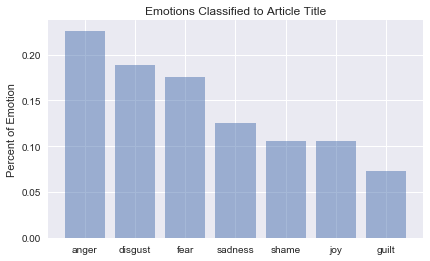

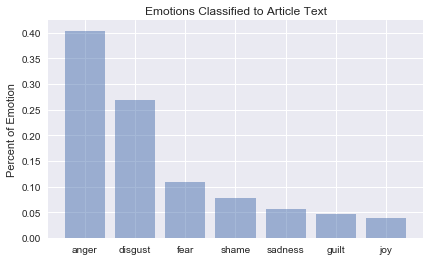

In [18]:
title_emotion = []
title_totals = []
title_sum = 0
for each in title_sentiment:
    title_emotion.append(each[0])
    title_totals.append(each[1]/12999)
    
text_emotion = []
text_totals = []
text_sum = 0
for each in text_sentiment:
    text_emotion.append(each[0])
    text_totals.append(each[1]/12999)
print(text_totals)
print(title_totals)
    
# the list of each emotion and the percent of each classified type for the title of the article.
y_pos = numpy.arange(len(title_emotion))
 
plt.bar(y_pos, title_totals, align='center', alpha=0.5)
plt.xticks(y_pos, title_emotion)
plt.ylabel('Percent of Emotion')
plt.title('Emotions Classified to Article Title')
plt.show()

# the list of each emotion and the percent of each classified type for the text of the article.
y_pos = numpy.arange(len(text_emotion))
 
plt.bar(y_pos, text_totals, align='center', alpha=0.5)
plt.xticks(y_pos, text_emotion)
plt.ylabel('Percent of Emotion')
plt.title('Emotions Classified to Article Text')
plt.show()

#### Inferences:

> This sentiment analysis of titles and text of each post conveys following results

- Majority of article text and titles were classified to anger followed by disgust and fear 
- Titles are short and less accurate. Text are more accurate and belivable. 
- Most of the news are based on defaming a person/group of people rather than promoting them. Example: Political Affiliations. 

## Topics – LDA (latent Dirichlet allocation )  to list the topics of types of Fake News

- The article has a type tag which tells more about the specific type of the news. Most of the data about 11,000 of 13,000 were missing a type. Where 'bs' is given as the replacement. 
- The dataset has huge bias. There is significantly large amount of dataset scraped on first few days when compared to the last few days.  

***My Solution:***
    
- Enrich the data using Opensources publicly accessable file sources.json which has reliable websites with type associated with it. Match the email and update the type in the given fake.csv data set. 
- Plot the individual fake news using matplotlib library with nofo bins set up to 30 to accurately present the 30-day span of data. 

{'bs', 'fake', 'state', 'hate', 'junksci', 'conspiracy', 'satire', 'bias'}
[('bs', 10900), ('fake', 19), ('state', 120), ('hate', 243), ('junksci', 102), ('conspiracy', 430), ('satire', 100), ('bias', 443)]


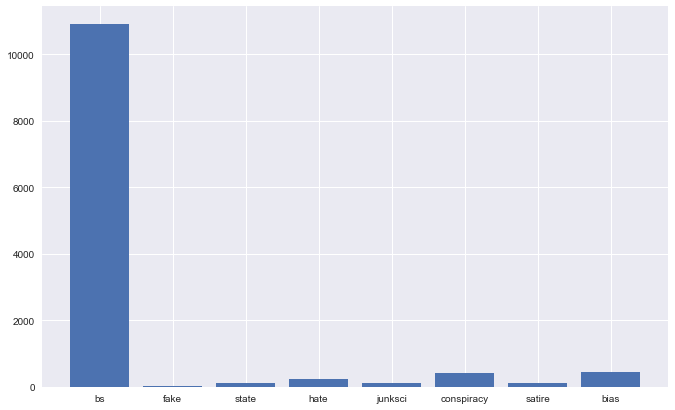

In [19]:
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


print(set(df.type))

satire = df[df.type=='satire']
consp = df[df.type=='conspiracy']
consp = consp[~consp.text.str.contains("Brain Force")]
state = df[df.type=='state']
bs = df[df.type=='bs']
bias = df[df.type=='bias']
fake = df[df.type=='fake']
junksci = df[df.type=='junksci']
hate = df[df.type=='hate']
data = df[~df.text.str.contains("Brain Force")]
types = set(df.type)
sizes = []
for t in types:
    sizes.append((t, df[df.type==t].shape[0]))
print(sizes)

plt.figure(figsize=[10,7])
plt.bar(left = [x for x in range(len(types))], height = [x[1] for x in sizes])
plt.xticks([x for x in range(len(types))], [x[0] for x in sizes])
plt.show()

##### Inferences from the Dataset type composition
> By far the most news are the ones labelled as 'bs'. Seems that this category is a throw it all that features a lot of data that would otherwise be in another category. Biased news, conspiracy theories, hate news and junkscience follow.

#### Data Enrichment 
- http://www.opensources.co/
- https://github.com/bs-detector/bs-detector

In [20]:
def load_domains(file):
    """loads the json file of domains"""
    with open(file, 'r') as line:
        domain = json.load(line)
    return domain
        
domains = load_domains("input_data/sources.json")
  
def fix_unknown_types(data, domains):
    """replaces the unknown-bs types with the type associated with the url
    in the json file"""
    for keys, values in domains.items():
        for dicts in data:
            if(dicts["type"] == 'bs'):
                if(dicts["site_url"] == keys):
                    dicts["type"] = values["type"]
    return data

news_data = fix_unknown_types(news_data, domains)

#### Total word count analysis

In [21]:
to_ignore = 'in they you a not that who but were we from be their has your their than them with how the to this are as of – and if or his her an have is on what no he she by for'

def clean_words(data):
    """This function prepares the words in the 'text' and 'title' part of the data for a total word count analysis"""
    exclude = set(punctuation)
    for dicts in data:
        text_replace = [ char for char in dicts["text"] if char not in exclude ]
        title_replace = [ char for char in dicts["title"] if char not in exclude ]
        # to rejoin the individual characters
        text_replace = "".join(text_replace)
        title_replace = "".join(title_replace)
        # replaces the text in form 
        dicts["text"] = text_replace.lower()
        dicts["title"] = title_replace.lower()
    return data

def count_title_words(data):
    """Counts the total number of words in the tile part of data
    returns a sorted dictionary of words as keys and counts as values"""
    title_dict = {}
    for dicts in data:
        list_words = dicts['title'].strip().split()
        for word in list_words:
            if word in title_dict.keys() and word not in to_ignore:
                title_dict[word] += 1
            elif word != None and word not in to_ignore:
                title_dict.update({word:1})
    title_dict = sorted(title_dict.items(), key=lambda t : t[1], reverse=True)
    return title_dict

word_news_data = clean_words(word_news_data)

title_counts = count_title_words(word_news_data)
print("Title Counts")
for word in title_counts[:20]:
    print(word[0] + ": ", word[1])
    

Title Counts
trump:  1485
hillary:  1077
clinton:  978
us:  673
election:  573
new:  523
video:  469
will:  441
news:  418
fbi:  395
comment:  387
about:  383
war:  382
russia:  366
after:  356
donald:  320
world:  314
just:  296
why:  284
obama:  280


### TF-IDF  Vectorization 

In [22]:
n_samples = 2000
n_features = 1000
n_components = 6
n_top_words = 12
def print_top_words(model, feature_names, n_top_words):
    
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def get_topics(texts):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words=stop_words)
    tfidf = tfidf_vectorizer.fit_transform(texts)
    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5).fit(tfidf)

    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)

In [23]:
# Except Clickbait which is based on the Social Website likes and comments
print("Extreame Bias:")
print(get_topics(bias.text))
print("\n\n")
print("Conspiracy Theory:")
print(get_topics(consp.text))
print("\n\n")
print("Rumor Mill:")
print(get_topics(bs.text))
print("\n\n")
print("Satire:")
print(get_topics(satire.text))
print("\n\n")
print("State News:")
print(get_topics(state.text))
print("\n\n")
print("Fake News:")
print(get_topics(fake.text))
print("\n\n")
print("Hate Group:")
print(get_topics(hate.text))
print("\n\n")
print("Junk Science:")
print(get_topics(junksci.text))
print("\n\n")

Extreame Bias:

Topics in NMF model (Frobenius norm):
Topic #0: trump donald voters campaign election presidential nominee president vote republican percent 2016
Topic #1: account comment facebook article via disqus follow us times officer political popular
Topic #2: clinton hillary emails email campaign fbi voters republicans server podesta obama news
Topic #3: said people one would obama get president time american media country could
Topic #4: comey fbi letter director emails investigation election information james republicans partisan department
Topic #5: kelly gingrich megyn fox sex women sexual ago long show speaker position

None



Conspiracy Theory:

Topics in NMF model (Frobenius norm):
Topic #0: clinton foundation podesta band hillary bill campaign email wikileaks memo teneo million
Topic #1: youtube www https watch com part child video fraud oct 2016 21
Topic #2: trump election clinton hillary donald said percent would people voting vote democratic
Topic #3: syria russia a

##### Topic Modeling - Inferences

> Ok, so now that is done the topics we get here are very different from the typology presented in the dataset. Indeed they are actual topics covered in the dataset. We see that the Clinton e-mail scandal features on its own in two different topics - one that covers a more legal stance and one that focuses more on the scandal itself.

> The major take-away is that fake-news seem to follow the scandals and important events of the day and seem to connect with them. An exception to this would be the natural news topics, which would follow its own niche that does not necessary reflect the big news. We can in fact do the same topic analysis on each of the subgroups of fake news we have

-----

#### WordClouds 

> Lets have a look at the wordclouds of the texts of the news in the major categories. Initially all clouds had the names of the presidential candidates as well as former president Obama feature prominently. So, I added them to the stopwords, to see what else is there.
> At first glance the junk science news seem to stand on its own, as it features a lot more health related words. Most other 'fake news' seem to be overly political.
>It seems there is quite the little marketing campaign going on in conspiracy. Might also be the case that most of those news come exclusively from infowars.
> **Next step would be comparing word distributions and trying to do PCAs, clustering, etc**

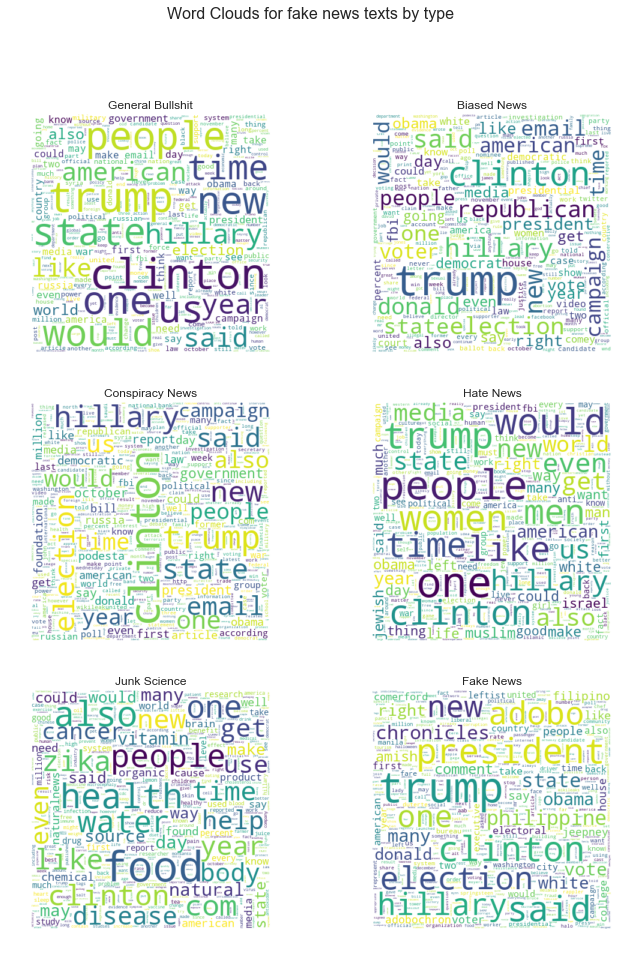

In [24]:
def make_wordcloud(texts, stopwords, title="Wordcloud", plot=True):
    """
    Helper function that will plot a word cloud from a text or list of texts
    """
    if type(texts) is list:
        texts = ' '.join(texts)
    texts = texts.lower()
    wordcloud = WordCloud(max_font_size=70,
                          background_color="white",
                          max_words=2000,
                          collocations=False,
                          width=400,
                          height=400,
    
                          stopwords=stopwords).generate(texts)
    if not plot:
        return wordcloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
n_cols = 2
n_rows = 3
f, axes = plt.subplots(n_rows, n_cols, figsize=[10,15], sharex='all', sharey='all')
#print(axes)

plt.suptitle("Word Clouds for fake news texts by type", fontsize=16)
axes[0, 0].imshow(make_wordcloud(list(bs.text), stop_words, "General Bullshit", plot=False), interpolation="bilinear")
axes[0, 0].set_title("General Bullshit")
axes[0, 0].axis("off")
axes[0 ,1].imshow(make_wordcloud(list(bias.text), stop_words, "Biased News", plot=False), interpolation="bilinear")
axes[0, 1].set_title("Biased News")
axes[0, 1].axis("off")
axes[1, 0].imshow(make_wordcloud(list(consp.text), stop_words, "Conspiracy news", plot=False), interpolation="bilinear")
axes[1, 0].set_title("Conspiracy News")
axes[1, 0].axis("off")
axes[1, 1].imshow(make_wordcloud(list(hate.text), stop_words, "Hate news", plot=False), interpolation="bilinear")
axes[1, 1].set_title("Hate News")
axes[1, 1].axis("off")
axes[2, 0].imshow(make_wordcloud(list(junksci.text), stop_words, "Junk Science news", plot=False), interpolation="bilinear")
axes[2, 0].set_title("Junk Science")
axes[2, 0].axis("off")
axes[2, 1].imshow(make_wordcloud(list(fake.text), stop_words, "Fake news", plot=False), interpolation="bilinear")
axes[2, 1].set_title("Fake News")
axes[2, 1].axis("off")

plt.show()

### Training and Testing datasets for modeling 

In [25]:
from sklearn.model_selection import train_test_split
X = df.text
y = df.type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
vect = CountVectorizer(max_features=1000, binary=True)
X_train_vect = vect.fit_transform(X_train)

### SMOTE looks at the minor class, positives in our case, and creates new, synthetic training examples

In [27]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

In [28]:
unique, counts = numpy.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[('bias', 8710), ('bs', 8710), ('conspiracy', 8710), ('fake', 8710), ('hate', 8710), ('junksci', 8710), ('satire', 8710), ('state', 8710)]


### Naive Bayes model on the fake news text and types

In [29]:
nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)
y_pred = nb.predict(X_train_res)
nb.score(X_train_res, y_train_res)

0.7803386911595867

In [30]:
counts = df.type.value_counts()
print(counts)
print("\nPredicting only -1 = {:.2f}% accuracy".format(counts[-1] / sum(counts) * 100))

bs            10900
bias            443
conspiracy      430
hate            243
state           120
junksci         102
satire          100
fake             19
Name: type, dtype: int64

Predicting only -1 = 0.15% accuracy


#### Confusion matrix 

Text(0.5,16,'Predicted label')

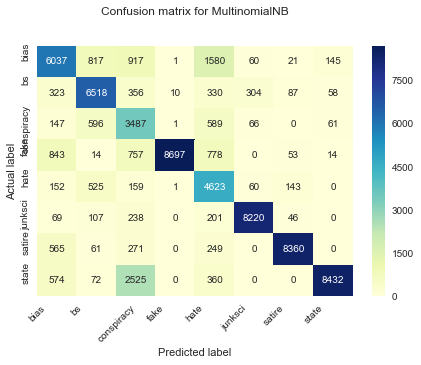

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_train_res)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
tick_marks = numpy.arange(len(unique))
plt.xticks(tick_marks, unique, rotation=45)
plt.yticks(tick_marks, unique)
plt.title('Confusion matrix for MultinomialNB', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Inferences From Bias/ News Types Factor

> Based on the above model, the Bias score is 78%. Thus based on the type of the news with reliable resources, we can predict if a news is fake or not.  

In [32]:
# Smarter cleanup and apply to dataset. 
import re
full_data = " ".join(list(df.title)).lower()
full_data = re.sub(r'[^\x00-\x7f]',"",full_data) 
full_data = re.sub(r"\d+", "", full_data)

words = [x for x in full_data.split(" ") if x not in stop_words]

bigrams = list(nltk.bigrams(words))
fdist = nltk.FreqDist(bigrams)
print(fdist.most_common(100))

[(('', ''), 384), (('hillary', 'clinton'), 317), (('donald', 'trump'), 226), (('world', 'war'), 111), (('-', "america's"), 101), (('onion', '-'), 99), (("america's", 'finest'), 99), (('finest', 'news'), 99), (('news', 'source'), 99), (('-', 'onion'), 96), (('standing', 'rock'), 91), (('', 'truthfeed'), 88), (('war', ''), 85), (('', ':'), 74), (('-', 'russia'), 66), (('clinton', 'campaign'), 64), (('russia', 'news'), 63), (('clinton', 'foundation'), 63), (('', 'years'), 59), (('hillary', 'clintons'), 57), (('dakota', 'access'), 52), ((':', 'information'), 51), (('election', ''), 50), (('white', 'house'), 48), (('election', 'day'), 45), (('|', 'new'), 44), (('new', 'eastern'), 44), (('eastern', 'outlook'), 44), (('', 'things'), 41), (('access', 'pipeline'), 41), (('', 'new'), 40), (('fbi', 'director'), 40), (('news', 'network'), 40), (('united', 'states'), 39), (('email', 'investigation'), 38), (('trump', 'supporters'), 38), (('bill', 'clinton'), 38), (('trump', ''), 37), (('$', 'million

Index(['likes', 'shares', 'comments'], dtype='object')


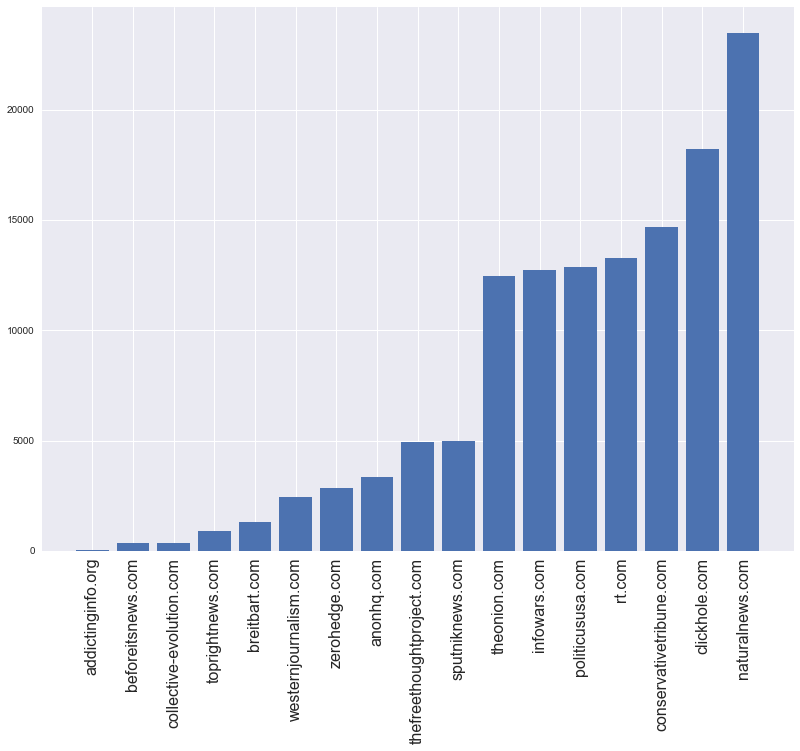

                           likes  shares  comments
site_url                                          
addictinginfo.org             29      29         1
beforeitsnews.com            338     338         0
collective-evolution.com     361     361         3
toprightnews.com             912     912         0
breitbart.com               1317    1317         0
westernjournalism.com       2447    2447        12
zerohedge.com               2834    2834         0
anonhq.com                  3348    3348         0
thefreethoughtproject.com   4939    4939        15
sputniknews.com             4988    4988       102
theonion.com               12451   12451         0
infowars.com               12745   12745         0
politicususa.com           12871   12871         0
rt.com                     13259   13259         0
conservativetribune.com    14659   14659       216
clickhole.com              18226   18226         2
naturalnews.com            23473   23473         0


In [33]:
shared_data = df[['site_url', 'likes', 'shares', 'comments']]
shared_data = shared_data[(shared_data.likes>0) | (shared_data.shares>0) | (shared_data.comments>0)]
shared_data_counts = shared_data.groupby('site_url').sum().sort_values(by=['shares'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.likes))], height = list(shared_data_counts.shares))
plt.xticks([x for x in range(len(shared_data_counts.likes))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.show()
print(shared_data_counts)

Index(['likes', 'shares', 'comments'], dtype='object')


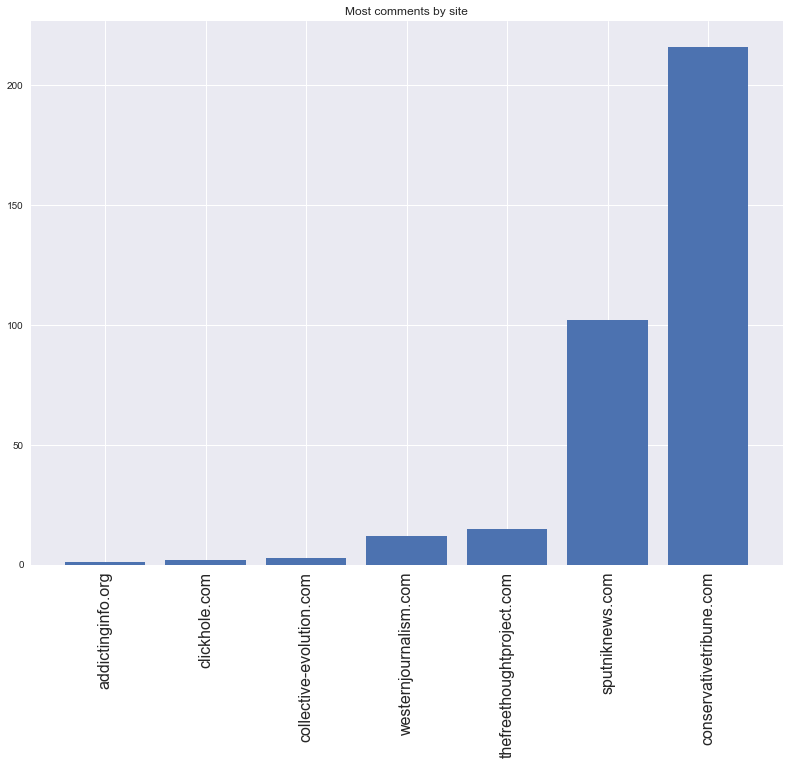

                           likes  shares  comments
site_url                                          
addictinginfo.org              4       4         1
clickhole.com                331     331         2
collective-evolution.com     138     138         3
westernjournalism.com       2252    2252        12
thefreethoughtproject.com     95      95        15
sputniknews.com             3886    3886       102
conservativetribune.com    12531   12531       216


In [34]:
shared_data = df[[ 'site_url', 'likes', 'shares', 'comments']]
shared_data = shared_data[(shared_data.comments>0)]
shared_data_counts = shared_data.groupby('site_url').sum().sort_values(by=['comments'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.comments))], height = list(shared_data_counts.comments))
plt.xticks([x for x in range(len(shared_data_counts.comments))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.title("Most comments by site")
plt.show()
print(shared_data_counts)

In [35]:
df[df.comments==df.comments.max()]

,author,published,title,text,language,site_url,likes,comments,shares,type,tokenized
8112,John Falkenberg,2016-10-27T01:44:38.370+03:00,Trump Haters Boycott Ivanka’s Clothing Line Be...,"“That is what ‘Trump’ means to me,” she said. ...",english,conservativetribune.com,16,30,16,bs,"[trump, mean, said, doesnt, matter, ivanka, na..."


Index(['likes', 'shares', 'comments'], dtype='object')


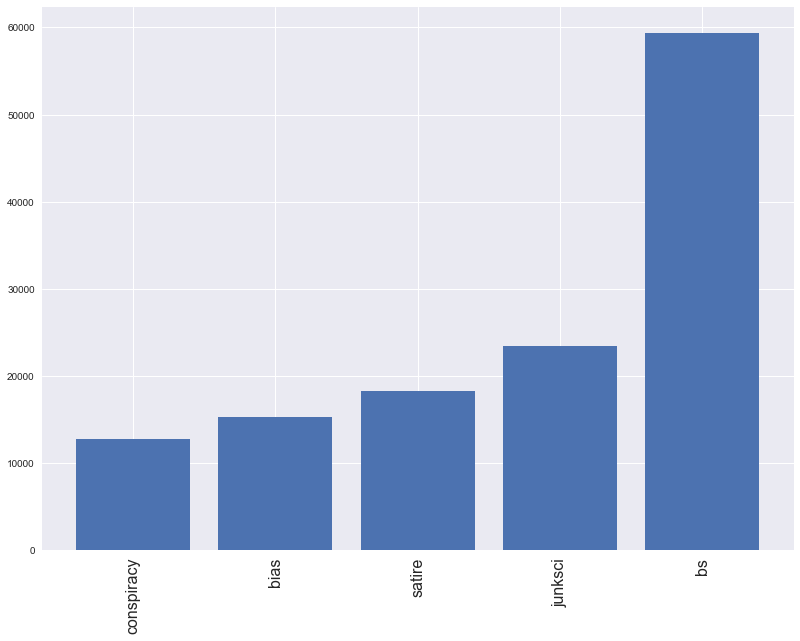

            likes  shares  comments
type                               
conspiracy  12745   12745         0
bias        15347   15347        13
satire      18226   18226         2
junksci     23473   23473         0
bs          59406   59406       336


In [36]:
shared_data = df[['site_url', 'type', 'likes', 'shares', 'comments']]
shared_data = shared_data[(shared_data.likes>0) | (shared_data.shares>0) | (shared_data.comments>0)]
shared_data_counts = shared_data.groupby('type').sum().sort_values(by=['shares'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.likes))], height = list(shared_data_counts.shares))
plt.xticks([x for x in range(len(shared_data_counts.likes))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.show()
print(shared_data_counts)

### Training and Testing datasets for modeling 

In [37]:
from sklearn.model_selection import train_test_split
X = df.site_url
y = df.likes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
vect = CountVectorizer(max_features=1000, binary=True)
X_train_vect = vect.fit_transform(X_train)

### Naive Bayes model on the fake news text and types

In [39]:
nb = MultinomialNB()
nb.fit(X_train_vect , y_train)
y_pred = nb.predict(X_train_vect )
nb.score(X_train_vect, y_train)

0.9606474456246838

#### Inferences from Social Acceptance Classification 
- Most likely if a news is published my a popular reliable website, it is most likely to get more likes, shares and comemnts. This could help us to predit if a news published in a website is real or fake. 
- But there are chances that even a reliable website posts fake-like news for publicity. In this case, the prediction might go wrong. 
- Thus in the given dataset, the user likes for the news publishes in on a reliable websiteis 96% accurate.

## Polynomial equation for coming up with a Fake News score

|Factors | Classification Model Accuracy| Weightage
|---|---|---|
|Sentiments/Sensationalism | 82% | 0.30 |
|News Type/ Bias Score | 78% | 0.25 |
|Social acceptance | 96% | 0.45 |